In [1]:
import numpy as np
from matplotlib import pyplot as plt

import polpo.preprocessing.dict as ppdict
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.preprocessing import BranchingPipeline, IdentityStep
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.decimation import PvDecimate

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
session_subset = np.random.choice(np.arange(1, 27))

mesh_loader = (
    MeshLoader(
        subject_subset=["01"],
        struct_subset=["L_Hipp"],
        session_subset=[session_subset],
        derivative="enigma",
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey(nested=True)
    + PvSurface
)

raw_mesh = mesh_loader()

session_subset

np.int64(3)

In [3]:
decimation_targets = [0.6, 0.5, 0.2, 0]


multi_decimation_pipe = BranchingPipeline(
    [
        (
            PvDecimate(target_reduction=target_reduction, volume_preservation=True)
            + PvSurface
            if target_reduction
            else IdentityStep()
        )
        for target_reduction in decimation_targets
    ],
    merger=lambda data: dict(zip(decimation_targets, data)),
)

meshes = multi_decimation_pipe(raw_mesh)


[mesh.n_points for mesh in meshes.values()]

[1002, 1252, 2002, 2502]

In [4]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)

In [5]:
sigmas = []
for mesh in meshes.values():
    sigma_search.fit([mesh])

    sigmas.append(sigma_search.sigma_)

sigmas

[np.float64(5.598015785217285),
 np.float64(5.638864040374756),
 np.float64(5.629452228546143),
 np.float64(5.613590858837766)]

In [6]:
metric = sigma_search.optimal_metric_

dists = []
for mesh in meshes.values():
    dists_ = []
    dists.append(dists_)
    for cmp_mesh in meshes.values():
        dists_.append(metric.dist(mesh, cmp_mesh))

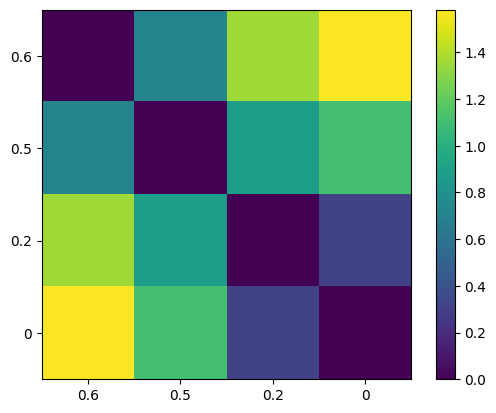

In [7]:
fig, ax = plt.subplots()

im = ax.imshow(dists)

plt.colorbar(im)


ax.set_xticks(range(len(decimation_targets)))
ax.set_xticklabels(decimation_targets)

ax.set_yticks(range(len(decimation_targets)))
ax.set_yticklabels(decimation_targets);